In [46]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
df = pd.read_csv('/content/drive/MyDrive/all_faults.csv')

In [49]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=784
stride=450

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],28,28,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [50]:
X.shape

(6169, 28, 28, 1)

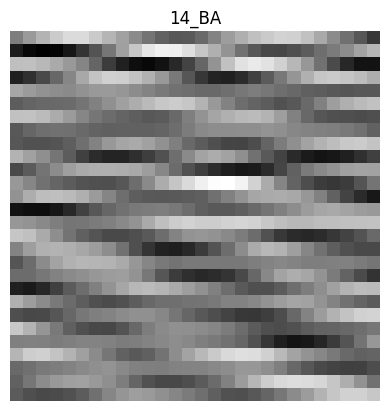

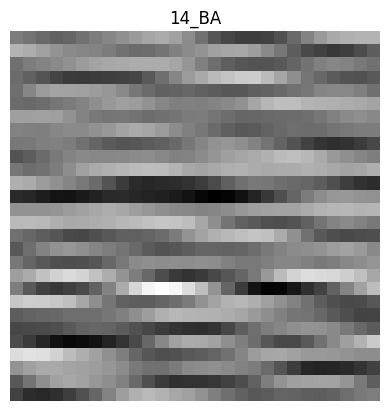

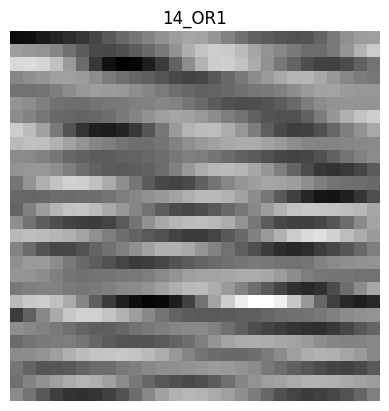

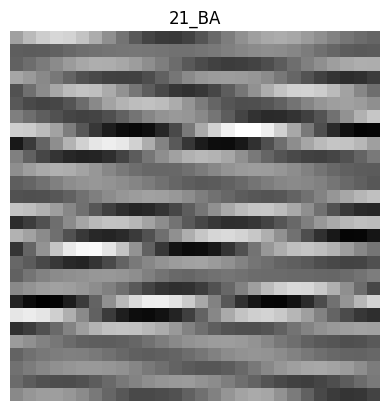

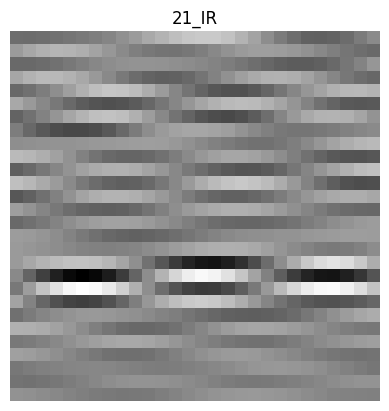

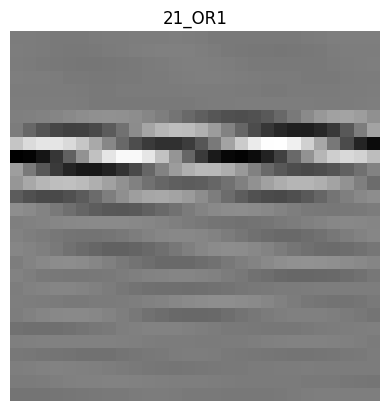

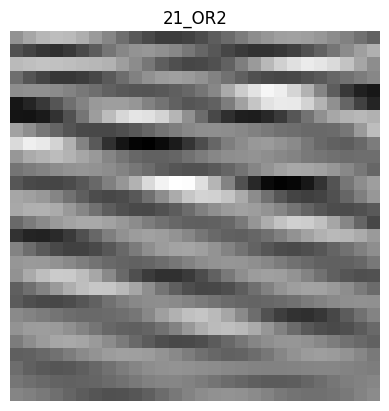

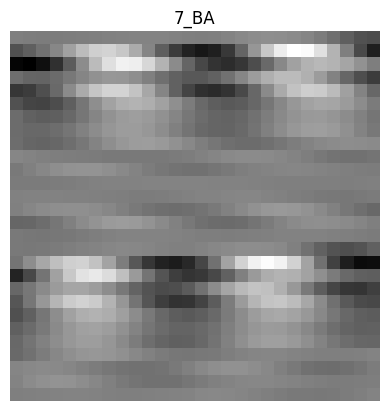

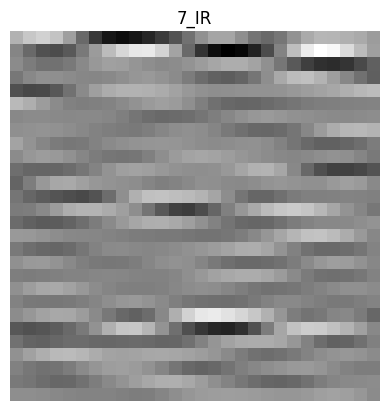

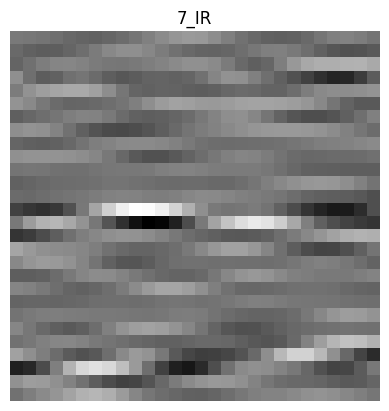

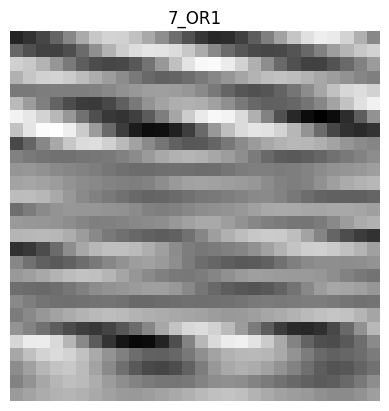

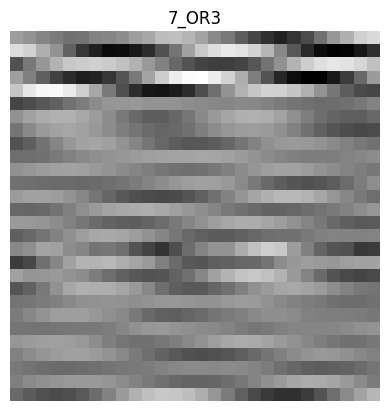

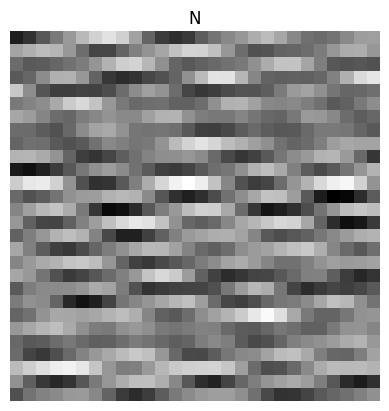

In [51]:
from matplotlib.pyplot import imread

X_len = len(X)
for idx in range(0,X_len,500):
    img = X[idx]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [52]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)


In [53]:
# X_pre_cnn = X.reshape(X.shape[0],X.shape[1]*X.shape[2])

# from sklearn.manifold import TSNE

# X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X_pre_cnn)

# tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

# tSNEdf['Fault']=Y


# # Plot the PC-1 and PC-2
# fig, ax = plt.subplots(figsize=(7,7))
# sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
#     data=tSNEdf,
#     legend="full",
#     alpha=0.3)
# plt.show()

In [54]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten ,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D ,BatchNormalization,AveragePooling2D



# from tensorflow.keras.models import load_model
# cnn_model = load_model(r'H:\Gear Fault\Trained Model\CNN_model_gear.h5')



no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(X.shape[1],X.shape[2],1),padding='same'))
cnn_model.add(AveragePooling2D((2, 2),strides=(2, 2),padding='same'))


cnn_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='same'))



# cnn_model.add(Conv2D(128, (5, 3), activation='relu',padding='same'))

# cnn_model.add(MaxPooling2D(pool_size=(5, 2),strides=(3, 3),padding='same'))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))

cnn_model.add(Dense(no_classes, activation='softmax'))

cnn_model.summary()

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 14, 14, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,158 (1.61 MB)

 Trainable params: 422,158 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
batch_size =200
epochs = 10
history = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,y_test),shuffle=True)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.1812 - loss: 2.3242 - val_accuracy: 0.3992 - val_loss: 1.6339
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.5305 - loss: 1.3767 - val_accuracy: 0.7326 - val_loss: 0.9114
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.8150 - loss: 0.7329 - val_accuracy: 0.8752 - val_loss: 0.4203
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.9111 - loss: 0.3407 - val_accuracy: 0.9136 - val_loss: 0.2833
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9361 - loss: 0.2203 - val_accuracy: 0.9368 - val_loss: 0.2008
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.9428 - loss: 0.1849 - val_accuracy: 0.9303 - val_loss: 0.2046
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.9551 - loss: 0.1357 - val_accuracy: 0.9584 - val_loss: 0.1597
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.9643 - loss: 0.1175 - val_accuracy: 0

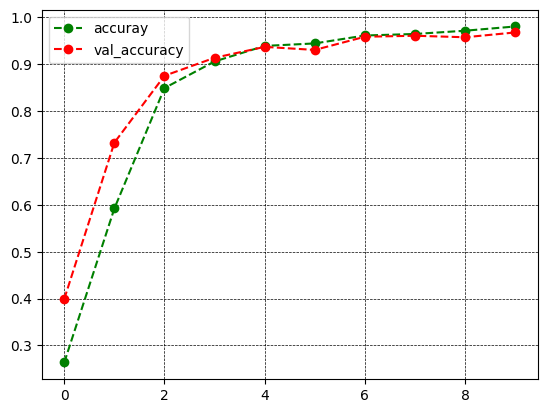

In [56]:
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['accuray','val_accuracy'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


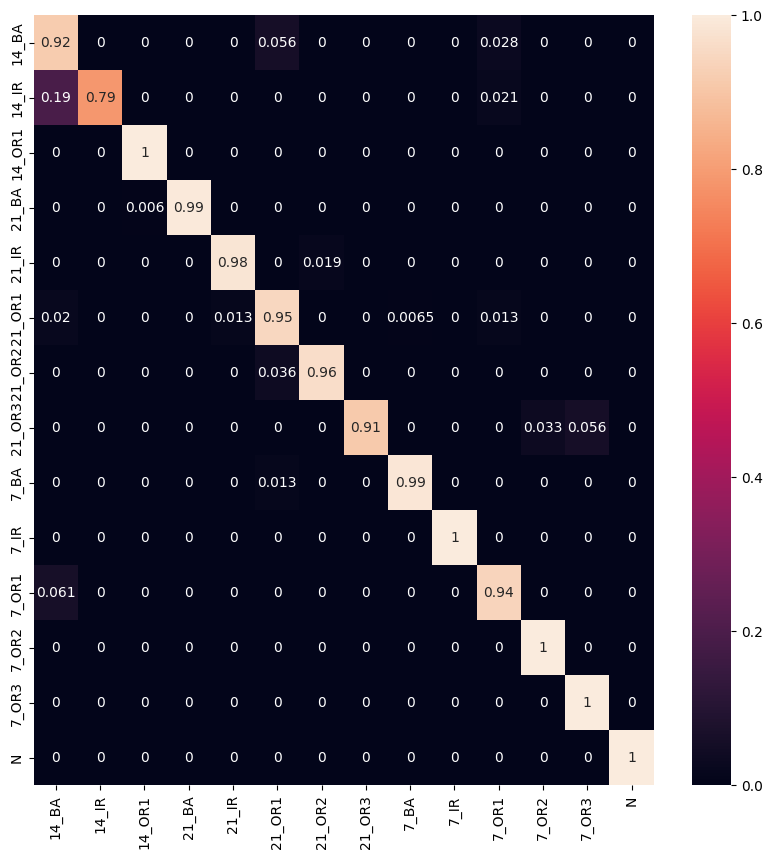

In [57]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

In [58]:
dummy_cnn = Model(inputs=cnn_model.layers[0].input,outputs=cnn_model.layers[6].output)
y_viz = dummy_cnn.predict(X_train)

135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4318 samples in 0.028s...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 4318 samples in 0.261s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4318
[t-SNE] Computed conditional probabilities for sample 2000 / 4318
[t-SNE] Computed conditional probabilities for sample 3000 / 4318
[t-SNE] Computed conditional probabilities for sample 4000 / 4318
[t-SNE] Computed conditional probabilities for sample 4318 / 4318
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.404797
[t-SNE] KL divergence after 300 iterations: 1.189129


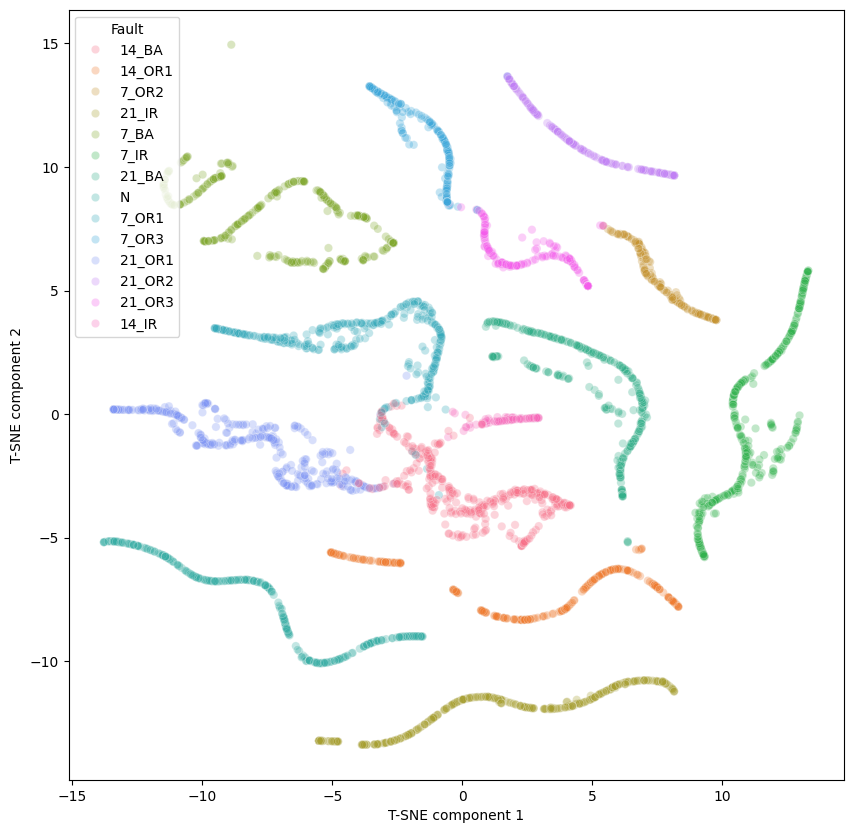

In [59]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [60]:
def T_SNE_plot(X_train,y_train,model):

    dummy_ann = Model(inputs=model.input,outputs=model.layers[-2].output)
    y_viz = dummy_ann.predict(X_train)

    from sklearn.manifold import TSNE

    X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

    tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

    tSNEdf['Fault']=inv_Transform_result(y_train)


    # Plot the PC-1 and PC-2
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
        data=tSNEdf,
        legend="full",
        alpha=0.3)
    plt.show()






def Test_model_diff_loading(load,win_len,stride,model):

    df = pd.read_csv('{}hp_all_faults.csv'.format(load))

#     win_len=1000
#     stride=200

    X=[]
    Y=[]


    for k in df['fault'].unique():

        df_temp_2 = df[df['fault']==k]

        for i in np.arange(0,len(df_temp_2)-(win_len),stride):
            temp = df_temp_2.iloc[i:i+win_len,:-1].values
            temp = temp.reshape((1,-1))
            X.append(temp)
            Y.append(df_temp_2.iloc[i+win_len,-1])

    X=np.array(X)
    X=X.reshape((X.shape[0],28,28,1))


    Y=np.array(Y)
    encoder2= LabelEncoder()
    encoder2.fit(Y)
    encoded_Y = encoder2.transform(Y)
    OHE_Y = to_categorical(encoded_Y)


    def inv_Transform_result(y_pred,encoder):
        y_pred = y_pred.argmax(axis=1)
        y_pred = encoder.inverse_transform(y_pred)
        return y_pred



    y_pred=model.predict(X)

    print('Accuracy on Load-{}hp data is---{}%'.format(load,(model.evaluate(X,OHE_Y)[1])*100))


    Y_pred=inv_Transform_result(y_pred,encoder2)
    Y_test = Y

    from sklearn.metrics import confusion_matrix


    plt.figure(figsize=(10,10))
    cm = confusion_matrix(Y_test, Y_pred,normalize='true')
    f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
    plt.show()
    print()

    T_SNE_plot(X[::2,:],OHE_Y[::2,:],model)

In [61]:
Test_model_diff_loading(load=1,win_len=784,stride=300,model=cnn_model)

FileNotFoundError: [Errno 2] No such file or directory: '1hp_all_faults.csv'

In [ ]:
Test_model_diff_loading(load=2,win_len=784,stride=300,model=cnn_model)

In [ ]:
Test_model_diff_loading(load=3,win_len=784,stride=300,model=cnn_model)